# Discrete Event Simulation (DES) of an Automated Teller Machine (ATM)

## Introduction
This activity introduces the concept of Discrete Event Simulation (DES) by modeling the operations of an Automated Teller Machine (ATM) system. You will learn how to simulate customer arrivals, ATM service, and various scenarios that can occur during a transaction, such as insufficient cash in the ATM, customer insufficient funds, and specific withdrawal denominations.


## Learning Objectives
Upon completion of this activity, you should be able to:
- Understand the basic principles of Discrete Event Simulation.
- Model a real-world system (ATM) using DES concepts.
- Implement event-driven simulation logic.
- Handle various scenarios and conditions within a simulation.
- Analyze and interpret simulation results.


## Problem Description: ATM Simulation

Simulate a bank with 3 ATM machines. The simulation should model customer interactions with the ATMs, considering the following scenarios:

### ATM Constraints and Scenarios:
1.  **Cash Dispensing Issues**: An ATM may not be able to dispense money due to:
    *   **No Available Cash**: The ATM has run out of cash.
    *   **Large Withdrawal Amount**: The customer attempts to withdraw an amount larger than the ATM's current cash reserves, or an amount that cannot be dispensed with available denominations.
    *   If an ATM cannot dispense the requested amount, the customer should attempt to use another available machine or re-enter the amount.
2.  **Customer Insufficient Funds**: A customer may have insufficient funds in their account to complete a withdrawal. In this case, the transaction should be declined.
3.  **Paper Money Denominations**: Customers can only withdraw money in denominations of 100, 500, and 1000.

### Simulation Requirements:
-   Model customer arrivals as a random process.
-   Model ATM service time.
-   Keep track of the state of each ATM (available, busy, out of cash).
-   Record key metrics such as:
    *   Average customer waiting time.
    *   Number of customers served.
    *   Number of rejected transactions (due to ATM cash, customer funds, or denomination issues).
    *   ATM utilization.


## Task: Data Visualization

To enhance the analysis of the ATM simulation, create meaningful plots and graphs based on the collected simulation metrics. The more visualizations, the better. Consider the following:

-   **Create Simulation Assumptions**: Formulate 5 clear and concise assumptions that underpin your simulation model. These assumptions should address aspects not explicitly defined in the problem description but are necessary for the simulation to run.
-   **Customer Waiting Time Distribution**: A histogram or density plot to show the distribution of customer waiting times.
-   **ATM Utilization**: A bar chart or pie chart showing the utilization of each ATM.
-   **Transaction Outcomes**: A bar chart or pie chart illustrating the proportion of successful transactions versus rejected transactions (categorized by reason: insufficient funds, ATM cash issues, no available ATM).
-   **Cash Remaining in ATMs**: A plot showing the cash level in each ATM over time (if time-series data is collected).
-   **Customers Served Over Time**: A line graph showing the cumulative number of customers served over the simulation duration.

Implement the code to generate these plots using appropriate Python libraries (e.g., `matplotlib`, `seaborn`, `plotly`).

SEE THE EXAMPLE PLOTS BELOW

In [65]:
import simpy
import random
import collections

# --- Configuration Parameters ---
RANDOM_SEED = random.randint(1, 10000)
NUM_ATMS = 3  # Number of ATM machines
ATM_CAPACITY = 200000  # Each ATM starts with 200,000 units of cash
DISPENSE_SERVICE_TIME = 0.10  # Time to dispense money (per Bank Note)
MIN_WITHDRAWAL = 1000
MAX_WITHDRAWAL = 10000
CUSTOMER_ARRIVAL_INTERVAL = 10  # Average time between customer arrivals (minutes)
SIM_DURATION = 500  # Simulation duration (minutes)

DENOMINATIONS = [1000, 500, 100]
CUSTOMER_FUNDS_RANGE = (1000, 100000) # Customers have between 1,000 and 100,000 in their account

# Set up random seed for reproducibility
random.seed(RANDOM_SEED)


In [66]:
class ATM:
    def __init__(self, env, name, capacity):
        self.env = env
        self.name = name
        self.cash = simpy.Container(env, init=capacity, capacity=capacity)

    def dispense_cash(self, amount):
        yield self.env.timeout(amount * DISPENSE_SERVICE_TIME / 100) # Simulate time to dispense
        self.cash.get(amount)

    def check_and_dispense(self, amount):
        if self.cash.level < amount:
            return False, "ATM has insufficient cash."

        # Check if amount can be dispensed with available denominations
        temp_amount = amount
        for denom in DENOMINATIONS:
            while temp_amount >= denom and self.cash.level >= denom:
                temp_amount -= denom
        if temp_amount != 0:
            return False, "Cannot dispense exact amount with available denominations."

        return True, "Cash can be dispensed."


In [67]:
def customer(env, name, atm_store, metrics):
    arrival_time = env.now
    print(f"{env.now:.2f}: Customer {name} arrived.")
    metrics['customers_arrived'] += 1

    withdrawal_amount = random.choice(DENOMINATIONS) * random.randint(1, 50) # Withdraw in multiples of 100, 500, 1000
    customer_funds = random.randint(*CUSTOMER_FUNDS_RANGE)

    print(f"{env.now:.2f}: Customer {name} wants to withdraw {withdrawal_amount} (has {customer_funds}).")

    if customer_funds < withdrawal_amount:
        print(f"{env.now:.2f}: Customer {name} has insufficient funds. Transaction rejected.")
        metrics['rejected_insufficient_funds'] += 1
        metrics['customer_waiting_times'].append(env.now - arrival_time)
        return

    # Customer tries to withdraw, potentially trying multiple ATMs
    transaction_successful = False
    attempts = 0
    while not transaction_successful and attempts < NUM_ATMS:
        attempts += 1
        print(f"{env.now:.2f}: Customer {name} waiting for an ATM (attempt {attempts}/{NUM_ATMS}).")
        
        # Request an ATM from the store
        with atm_store.get() as get_atm_request:
            atm = yield get_atm_request # Get an ATM from the store

            print(f"{env.now:.2f}: Customer {name} got ATM {atm.name}.")
            
            # Check ATM cash and denomination
            can_dispense, reason = atm.check_and_dispense(withdrawal_amount)
            if can_dispense:
                print(f"{env.now:.2f}: Customer {name} using ATM {atm.name} to withdraw {withdrawal_amount}.")
                yield env.process(atm.dispense_cash(withdrawal_amount))
                print(f"{env.now:.2f}: Customer {name} successfully withdrew {withdrawal_amount} from ATM {atm.name}. Remaining cash: {atm.cash.level}")
                metrics['customers_served'] += 1
                metrics['customer_waiting_times'].append(env.now - arrival_time)
                transaction_successful = True
            else:
                print(f"{env.now:.2f}: ATM {atm.name} cannot dispense for Customer {name}: {reason}")
                metrics['rejected_atm_issues'] += 1
                # Customer will try another ATM, so put this one back
                print(f"{env.now:.2f}: Customer {name} returning ATM {atm.name} and will try another.")
            
            yield atm_store.put(atm) # Return the ATM to the store

        if not transaction_successful and attempts < NUM_ATMS:
            # If transaction was not successful, wait a short time before trying another ATM
            yield env.timeout(1) # Simulate a small delay before trying again
    
    if not transaction_successful:
        print(f"{env.now:.2f}: Customer {name} could not withdraw from any ATM after {NUM_ATMS} attempts and left.")
        metrics['rejected_no_available_atm'] += 1
        metrics['customer_waiting_times'].append(env.now - arrival_time)
    else:
        print(f"{env.now:.2f}: Customer {name} completed transaction.")


In [68]:
def customer_generator(env, atm_store, metrics, arrival_interval):
    i = 0
    while True:
        yield env.timeout(random.expovariate(1.0 / arrival_interval))
        i += 1
        env.process(customer(env, f'{i}', atm_store, metrics))

def setup_environment(env, num_atms, atm_capacity):
    atms = [ATM(env, f'ATM {i+1}', atm_capacity) for i in range(num_atms)]
    atm_store = simpy.Store(env)
    for atm in atms:
        atm_store.put(atm)
    metrics = collections.defaultdict(int)
    metrics['customer_waiting_times'] = []
    return atms, atm_store, metrics


print("--- ATM Simulation ---")
env = simpy.Environment()
atms, atm_store, metrics = setup_environment(env, NUM_ATMS, ATM_CAPACITY)
env.process(customer_generator(env, atm_store, metrics, CUSTOMER_ARRIVAL_INTERVAL))
env.run(until=SIM_DURATION)

print("\n--- Simulation Metrics ---")
print(f"Customers Arrived: {metrics['customers_arrived']}")
print(f"Customers Served: {metrics['customers_served']}")
print(f"Rejected (Insufficient Funds): {metrics['rejected_insufficient_funds']}")
print(f"Rejected (ATM Issues): {metrics['rejected_atm_issues']}")
print(f"Rejected (No Available ATM): {metrics['rejected_no_available_atm']}")

if metrics['customer_waiting_times']:
    avg_wait_time = sum(metrics['customer_waiting_times']) / len(metrics['customer_waiting_times'])
    print(f"Average Customer Waiting Time: {avg_wait_time:.2f} minutes")
else:
    print("No customer waiting times to calculate.")

# Calculate ATM Utilization (simplified - could be more detailed)
for atm in atms:
    # This is a simplified view. A more accurate utilization would track busy time.
    # For now, we can infer based on cash dispensed.
    cash_dispensed = ATM_CAPACITY - atm.cash.level
    print(f"ATM {atm.name} Cash Remaining: {atm.cash.level} (Dispensed: {cash_dispensed})")


--- ATM Simulation ---
10.94: Customer 1 arrived.
10.94: Customer 1 wants to withdraw 500 (has 22861).
10.94: Customer 1 waiting for an ATM (attempt 1/3).
10.94: Customer 1 got ATM ATM 1.
10.94: Customer 1 using ATM ATM 1 to withdraw 500.
11.44: Customer 1 successfully withdrew 500 from ATM ATM 1. Remaining cash: 199500
11.44: Customer 1 completed transaction.
28.52: Customer 2 arrived.
28.52: Customer 2 wants to withdraw 4500 (has 62942).
28.52: Customer 2 waiting for an ATM (attempt 1/3).
28.52: Customer 2 got ATM ATM 2.
28.52: Customer 2 using ATM ATM 2 to withdraw 4500.
33.02: Customer 2 successfully withdrew 4500 from ATM ATM 2. Remaining cash: 195500
33.02: Customer 2 completed transaction.
39.75: Customer 3 arrived.
39.75: Customer 3 wants to withdraw 4800 (has 73063).
39.75: Customer 3 waiting for an ATM (attempt 1/3).
39.75: Customer 3 got ATM ATM 3.
39.75: Customer 3 using ATM ATM 3 to withdraw 4800.
44.55: Customer 3 successfully withdrew 4800 from ATM ATM 3. Remaining cash:

## Simulation Assumptions

Based on the problem description, here are 5 key assumptions for our ATM simulation:

1. **Customer Arrival Pattern**: Customer arrivals follow an exponential distribution with an average interval of 10 minutes, representing a realistic random arrival pattern for ATM usage.

2. **Service Time Model**: ATM service time is proportional to the number of bills dispensed (0.10 minutes per 100-unit denomination), representing the physical time needed to count and dispense cash.

3. **Customer Behavior**: When an ATM cannot fulfill a withdrawal request, customers will attempt to use other available ATMs up to the maximum number of machines (3 attempts) before leaving.

4. **Initial Cash Distribution**: All ATMs start with the same amount of cash (200,000 units) and operate independently without cash replenishment during the simulation period.

5. **Withdrawal Constraints**: Customers can only withdraw amounts that are multiples of available denominations (100, 500, 1000), and the system checks both customer account balance and ATM cash availability before processing transactions.

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [70]:
# Check available data
print("Available Metrics Keys:")
for i, key in enumerate(metrics.keys(), 1):
    print(f"{i}. {key.replace('_', ' ').title()}")

print(f"\nCustomer waiting times: {len(metrics['customer_waiting_times']) if metrics['customer_waiting_times'] else 0}")
print("Sample Waiting Times (first 5 customers):")
if metrics['customer_waiting_times']:
    for i, wait_time in enumerate(metrics['customer_waiting_times'][:5], 1):
        print(f"{i}. {wait_time:.2f} minutes")
else:
    print("   No data available")

# Check ATM data
print("\nATM Information:")
for i, atm in enumerate(atms, 1):
    cash_dispensed = ATM_CAPACITY - atm.cash.level
    utilization = (cash_dispensed / ATM_CAPACITY) * 100
    print(f"{i}. ATM {i}: ${atm.cash.level:,} remaining from ${ATM_CAPACITY:,} capacity")
    print(f"   - Cash dispensed: ${cash_dispensed:,}")
    print(f"   - Utilization: {utilization:.1f}%")

Available Metrics Keys:
1. Customer Waiting Times
2. Customers Arrived
3. Customers Served
4. Rejected Insufficient Funds
5. Rejected Atm Issues
6. Rejected No Available Atm

Customer waiting times: 41
Sample Waiting Times (first 5 customers):
1. 0.50 minutes
2. 4.50 minutes
3. 4.80 minutes
4. 4.60 minutes
5. 39.00 minutes

ATM Information:
1. ATM 1: $44,700 remaining from $200,000 capacity
   - Cash dispensed: $155,300
   - Utilization: 77.6%
2. ATM 2: $88,800 remaining from $200,000 capacity
   - Cash dispensed: $111,200
   - Utilization: 55.6%
3. ATM 3: $93,200 remaining from $200,000 capacity
   - Cash dispensed: $106,800
   - Utilization: 53.4%


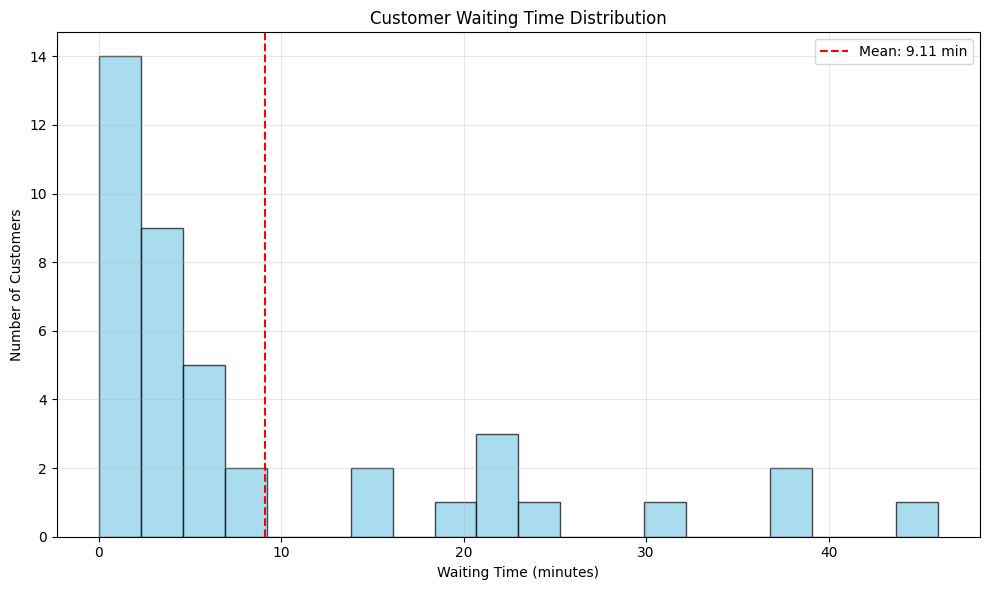

In [71]:
# 1. Customer Waiting Time Distribution
plt.figure(figsize=(10, 6))
if metrics['customer_waiting_times']:
    plt.hist(metrics['customer_waiting_times'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(metrics['customer_waiting_times']), color='red', linestyle='--', 
                label=f'Mean: {np.mean(metrics["customer_waiting_times"]):.2f} min')
    plt.xlabel('Waiting Time (minutes)')
    plt.ylabel('Number of Customers')
    plt.title('Customer Waiting Time Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No Data Available', ha='center', va='center')
    plt.title('Customer Waiting Time Distribution')
plt.tight_layout()
plt.show()

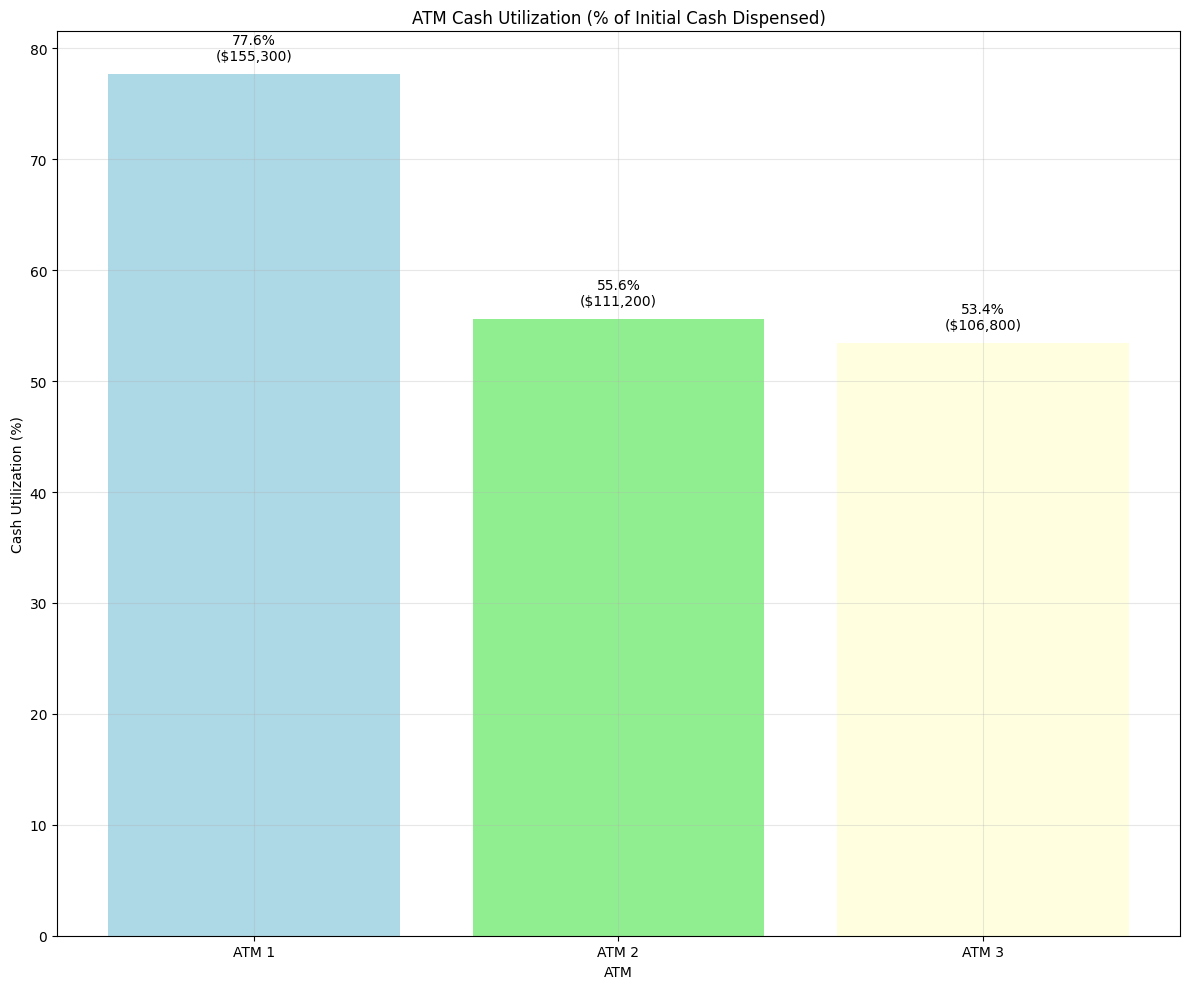

In [72]:
# 2. ATM Cash Utilization (Cash Dispensed)
plt.figure(figsize=(12, 10))
atm_labels = [f'ATM {i+1}' for i in range(len(atms))]
cash_dispensed = [ATM_CAPACITY - atm.cash.level for atm in atms]
utilization_pct = [(dispensed / ATM_CAPACITY) * 100 for dispensed in cash_dispensed]

plt.bar(atm_labels, utilization_pct, color=['lightblue', 'lightgreen', 'lightyellow'][:len(atms)])
plt.xlabel('ATM')
plt.ylabel('Cash Utilization (%)')
plt.title('ATM Cash Utilization (% of Initial Cash Dispensed)')
plt.grid(True, alpha=0.3)
for i, (pct, dispensed) in enumerate(zip(utilization_pct, cash_dispensed)):
    plt.text(i, pct + 1, f'{pct:.1f}%\n(${dispensed:,})', ha='center', va='bottom')
plt.tight_layout()
plt.show()

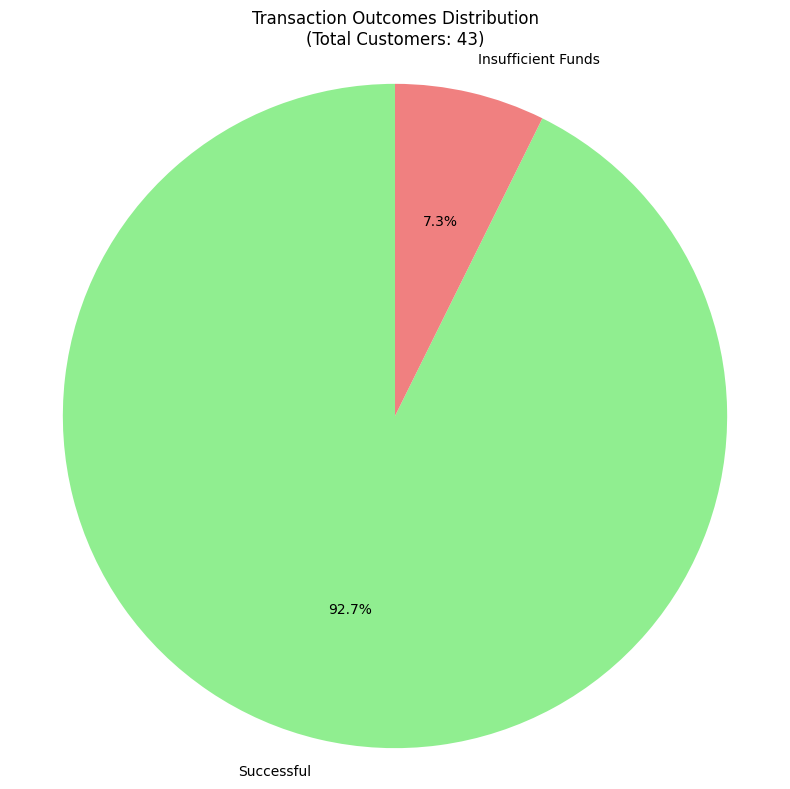

In [73]:
# 3. Transaction Outcomes Distribution
plt.figure(figsize=(8, 8))
outcomes = {
    'Successful': metrics['customers_served'],
    'Insufficient Funds': metrics['rejected_insufficient_funds'],
    'ATM Issues': metrics['rejected_atm_issues'],
    'No Available ATM': metrics['rejected_no_available_atm']
}
# Filter out zero values
outcomes = {k: v for k, v in outcomes.items() if v > 0}

if outcomes:
    colors = ['lightgreen', 'lightcoral', 'lightyellow', 'lightgray'][:len(outcomes)]
    plt.pie(outcomes.values(), labels=outcomes.keys(), autopct='%1.1f%%', 
            colors=colors, startangle=90)
    plt.title(f'Transaction Outcomes Distribution\n(Total Customers: {metrics["customers_arrived"]})')
else:
    plt.text(0.5, 0.5, 'No Data Available', ha='center', va='center')
    plt.title('Transaction Outcomes Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()

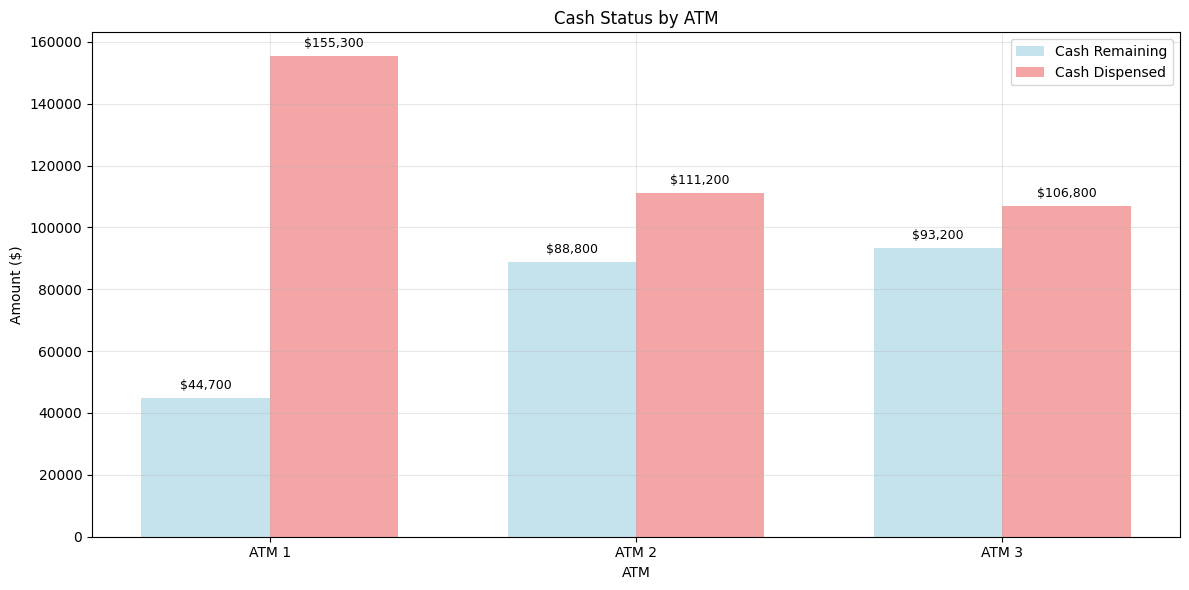

In [74]:
# 4. Cash Remaining in ATMs
plt.figure(figsize=(12, 6))
atm_names = [f'ATM {i+1}' for i in range(len(atms))]
cash_remaining = [atm.cash.level for atm in atms]
cash_dispensed = [ATM_CAPACITY - remaining for remaining in cash_remaining]

x = np.arange(len(atm_names))
width = 0.35

plt.bar(x - width/2, cash_remaining, width, label='Cash Remaining', color='lightblue', alpha=0.7)
plt.bar(x + width/2, cash_dispensed, width, label='Cash Dispensed', color='lightcoral', alpha=0.7)

plt.xlabel('ATM')
plt.ylabel('Amount ($)')
plt.title('Cash Status by ATM')
plt.xticks(x, atm_names)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for i, (remaining, dispensed) in enumerate(zip(cash_remaining, cash_dispensed)):
    plt.text(i - width/2, remaining + ATM_CAPACITY * 0.01, f'${remaining:,}', 
             ha='center', va='bottom', rotation=0, fontsize=9)
    plt.text(i + width/2, dispensed + ATM_CAPACITY * 0.01, f'${dispensed:,}', 
             ha='center', va='bottom', rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

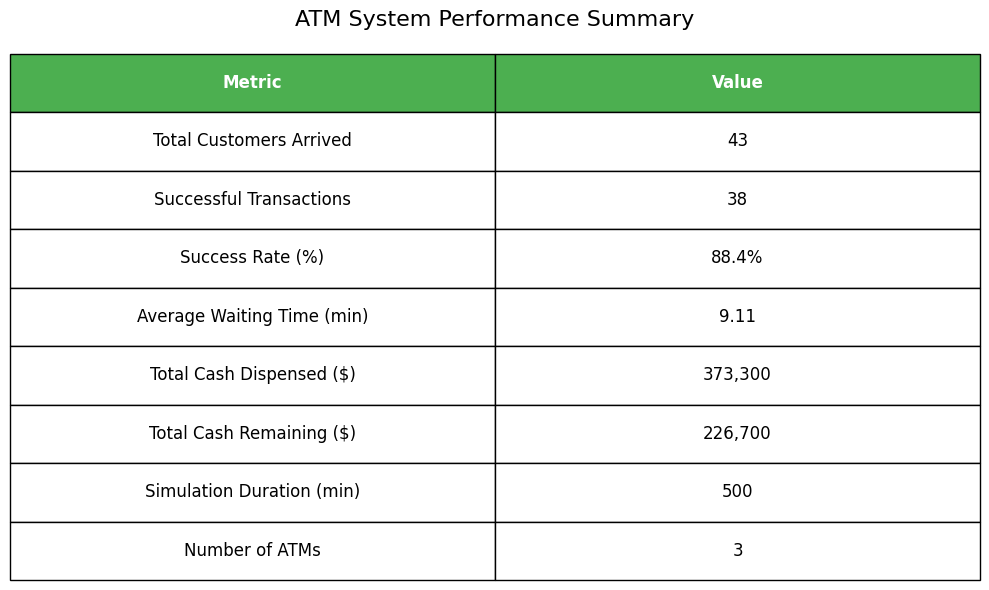

In [75]:
# 5. Summary Statistics Table
plt.figure(figsize=(10, 6))
plt.axis('off')

# Calculate derived statistics
total_cash_dispensed = sum(ATM_CAPACITY - atm.cash.level for atm in atms)
total_cash_remaining = sum(atm.cash.level for atm in atms)
avg_waiting_time = np.mean(metrics['customer_waiting_times']) if metrics['customer_waiting_times'] else 0
success_rate = (metrics['customers_served'] / metrics['customers_arrived'] * 100) if metrics['customers_arrived'] > 0 else 0

stats_data = [
    ['Total Customers Arrived', metrics['customers_arrived']],
    ['Successful Transactions', metrics['customers_served']],
    ['Success Rate (%)', f"{success_rate:.1f}%"],
    ['Average Waiting Time (min)', f"{avg_waiting_time:.2f}"],
    ['Total Cash Dispensed ($)', f"{total_cash_dispensed:,}"],
    ['Total Cash Remaining ($)', f"{total_cash_remaining:,}"],
    ['Simulation Duration (min)', SIM_DURATION],
    ['Number of ATMs', NUM_ATMS]
]

table = plt.table(cellText=stats_data, colLabels=['Metric', 'Value'], 
                  cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
# Color the header
for i in range(2):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('ATM System Performance Summary', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

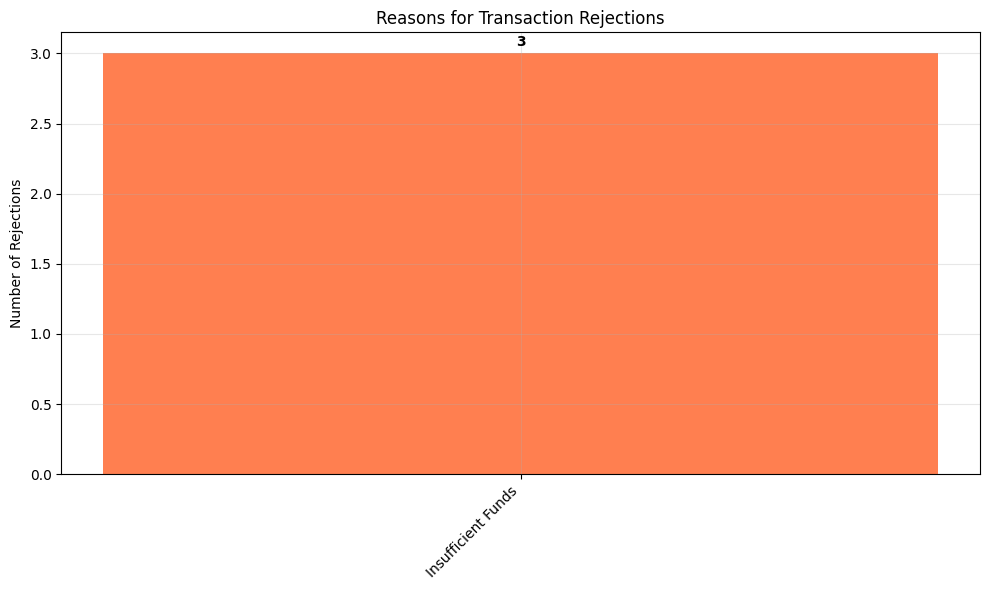

In [76]:
# 6. Transaction Rejection Reasons
plt.figure(figsize=(10, 6))
rejection_data = {
    'Insufficient Funds': metrics['rejected_insufficient_funds'],
    'ATM Issues': metrics['rejected_atm_issues'],
    'No Available ATM': metrics['rejected_no_available_atm']
}
# Filter out zero values
rejection_data = {k: v for k, v in rejection_data.items() if v > 0}

if rejection_data:
    plt.bar(range(len(rejection_data)), rejection_data.values(), 
            color=['coral', 'orange', 'lightcoral'][:len(rejection_data)])
    plt.xticks(range(len(rejection_data)), rejection_data.keys(), rotation=45, ha='right')
    plt.ylabel('Number of Rejections')
    plt.title('Reasons for Transaction Rejections')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (reason, count) in enumerate(rejection_data.items()):
        plt.text(i, count + max(rejection_data.values()) * 0.01, str(count), 
                ha='center', va='bottom', fontweight='bold')
else:
    plt.text(0.5, 0.5, 'No Rejections Recorded', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=14)
    plt.title('Reasons for Transaction Rejections')
    
plt.tight_layout()
plt.show()

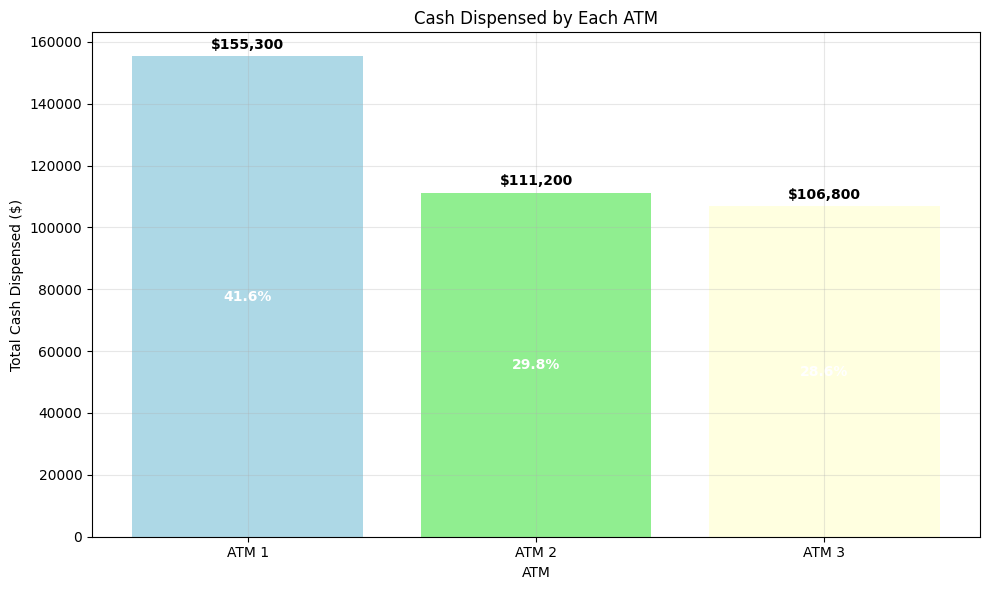

In [77]:
# 7. Cash Dispensed by ATM Comparison
plt.figure(figsize=(10, 6))
atm_names = [f'ATM {i+1}' for i in range(len(atms))]
cash_dispensed = [ATM_CAPACITY - atm.cash.level for atm in atms]

bars = plt.bar(atm_names, cash_dispensed, color=['lightblue', 'lightgreen', 'lightyellow'][:len(atms)])
plt.xlabel('ATM')
plt.ylabel('Total Cash Dispensed ($)')
plt.title('Cash Dispensed by Each ATM')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, cash_dispensed):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cash_dispensed) * 0.01, 
             f'${value:,}', ha='center', va='bottom', fontweight='bold')

# Add percentage labels
total_dispensed = sum(cash_dispensed)
for bar, value in zip(bars, cash_dispensed):
    pct = (value / total_dispensed * 100) if total_dispensed > 0 else 0
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 0.5, 
             f'{pct:.1f}%', ha='center', va='center', fontweight='bold', color='white')

plt.tight_layout()
plt.show()

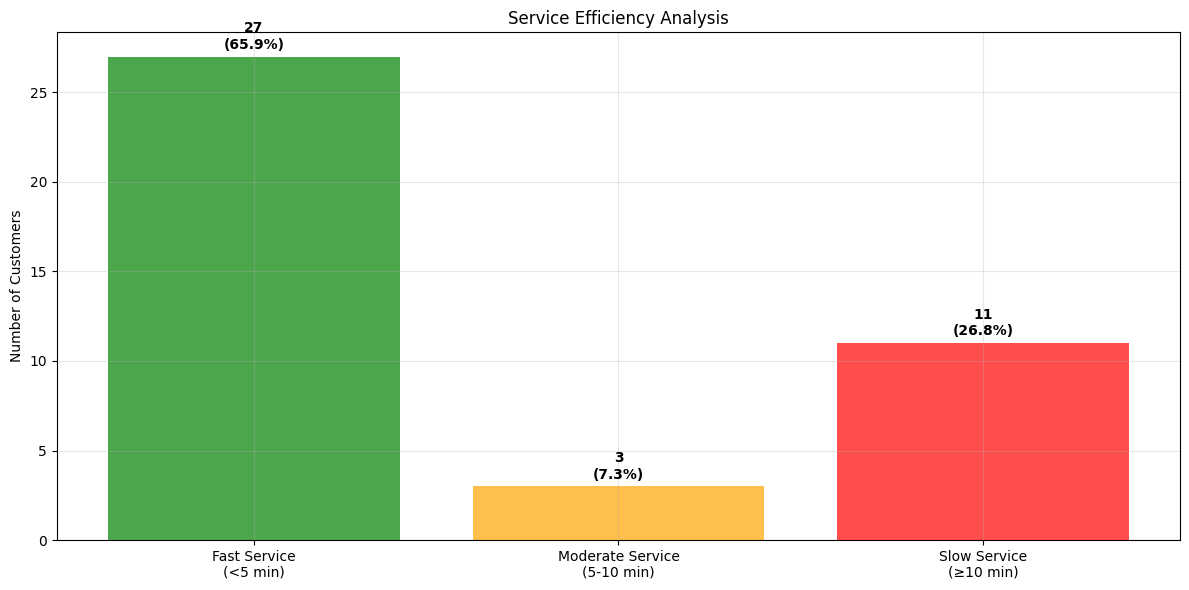

In [78]:
# 8. Service Efficiency Analysis
plt.figure(figsize=(12, 6))
if metrics['customer_waiting_times']:
    wait_times = metrics['customer_waiting_times']
    efficient_customers = len([t for t in wait_times if t < 5])  # Less than 5 min wait
    moderate_customers = len([t for t in wait_times if 5 <= t < 10])
    slow_customers = len([t for t in wait_times if t >= 10])
    
    efficiency_data = [efficient_customers, moderate_customers, slow_customers]
    efficiency_labels = ['Fast Service\n(<5 min)', 'Moderate Service\n(5-10 min)', 'Slow Service\n(≥10 min)']
    colors = ['green', 'orange', 'red']
    
    bars = plt.bar(efficiency_labels, efficiency_data, color=colors, alpha=0.7)
    plt.ylabel('Number of Customers')
    plt.title('Service Efficiency Analysis')
    plt.grid(True, alpha=0.3)
    
    # Add value labels and percentages
    total_customers = sum(efficiency_data)
    for bar, value in zip(bars, efficiency_data):
        pct = (value / total_customers * 100) if total_customers > 0 else 0
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(efficiency_data) * 0.01,
                 f'{value}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')
else:
    plt.text(0.5, 0.5, 'No Waiting Time Data Available', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=14)
    plt.title('Service Efficiency Analysis')

plt.tight_layout()
plt.show()

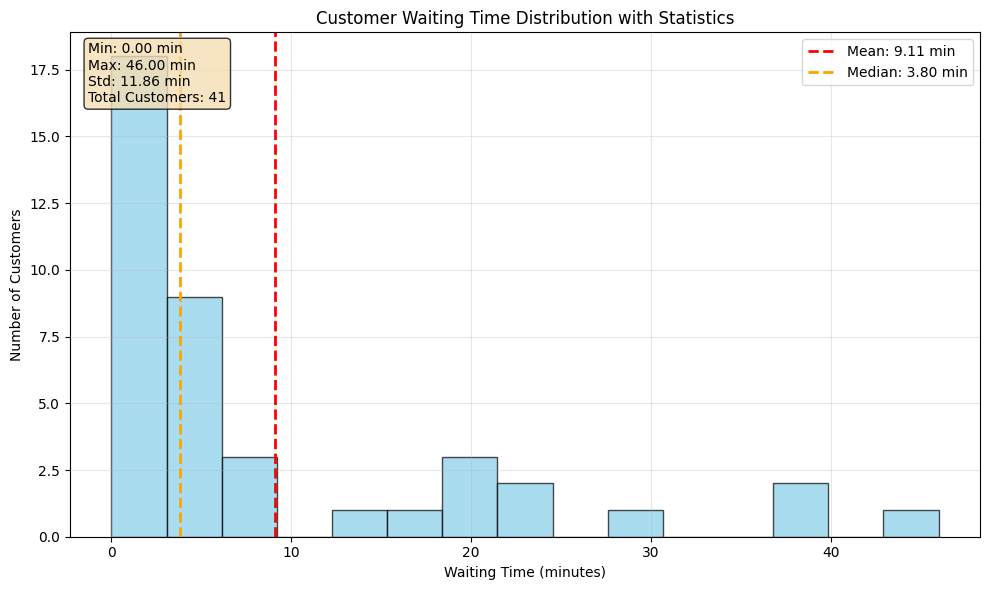

In [79]:
# 9. Waiting Time Statistics
plt.figure(figsize=(10, 6))
if metrics['customer_waiting_times']:
    wait_times = metrics['customer_waiting_times']
    
    # Create histogram
    plt.hist(wait_times, bins=15, alpha=0.7, color='skyblue', edgecolor='black', density=False)
    
    # Add statistical lines
    mean_wait = np.mean(wait_times)
    median_wait = np.median(wait_times)
    
    plt.axvline(mean_wait, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_wait:.2f} min')
    plt.axvline(median_wait, color='orange', linestyle='--', linewidth=2,
                label=f'Median: {median_wait:.2f} min')
    
    plt.xlabel('Waiting Time (minutes)')
    plt.ylabel('Number of Customers')
    plt.title('Customer Waiting Time Distribution with Statistics')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add text box with statistics
    stats_text = f'Min: {min(wait_times):.2f} min\nMax: {max(wait_times):.2f} min\nStd: {np.std(wait_times):.2f} min\nTotal Customers: {len(wait_times)}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
else:
    plt.text(0.5, 0.5, 'No Waiting Time Data Available', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=14)
    plt.title('Customer Waiting Time Distribution')

plt.tight_layout()
plt.show()

In [80]:
# Additional detailed analysis and reporting
print("="*60)
print("DETAILED ATM SIMULATION ANALYSIS REPORT")
print("="*60)

print(f"\n🏦 SIMULATION PARAMETERS:")
print(f"   • Simulation Duration: {SIM_DURATION} minutes")
print(f"   • Number of ATMs: {NUM_ATMS}")
print(f"   • Initial ATM Capacity: {ATM_CAPACITY:,} units each")
print(f"   • Average Customer Arrival Interval: {CUSTOMER_ARRIVAL_INTERVAL} minutes")
print(f"   • Available Denominations: {DENOMINATIONS}")
print(f"   • Random Seed: {RANDOM_SEED}")

print(f"\n👥 CUSTOMER STATISTICS:")
print(f"   • Total Customers Arrived: {metrics['customers_arrived']}")
print(f"   • Customers Successfully Served: {metrics['customers_served']}")
print(f"   • Customer Service Rate: {(metrics['customers_served']/metrics['customers_arrived']*100):.1f}%")

if metrics['customer_waiting_times']:
    wait_times = metrics['customer_waiting_times']
    print(f"   • Average Waiting Time: {np.mean(wait_times):.2f} minutes")
    print(f"   • Minimum Waiting Time: {min(wait_times):.2f} minutes")
    print(f"   • Maximum Waiting Time: {max(wait_times):.2f} minutes")
    print(f"   • Waiting Time Standard Deviation: {np.std(wait_times):.2f} minutes")

print(f"\n🚫 REJECTION ANALYSIS:")
total_rejected = (metrics['rejected_insufficient_funds'] + 
                 metrics['rejected_atm_issues'] + 
                 metrics['rejected_no_available_atm'])
print(f"   • Total Rejections: {total_rejected}")
print(f"   • Rejections due to Insufficient Customer Funds: {metrics['rejected_insufficient_funds']}")
print(f"   • Rejections due to ATM Issues: {metrics['rejected_atm_issues']}")
print(f"   • Rejections due to No Available ATM: {metrics['rejected_no_available_atm']}")

if total_rejected > 0:
    print(f"   • Insufficient Funds Rate: {(metrics['rejected_insufficient_funds']/total_rejected*100):.1f}%")
    print(f"   • ATM Issues Rate: {(metrics['rejected_atm_issues']/total_rejected*100):.1f}%")
    print(f"   • No Available ATM Rate: {(metrics['rejected_no_available_atm']/total_rejected*100):.1f}%")

print(f"\n🏧 ATM PERFORMANCE:")
total_initial_cash = NUM_ATMS * ATM_CAPACITY
total_remaining_cash = sum(atm.cash.level for atm in atms)
total_dispensed = total_initial_cash - total_remaining_cash

print(f"   • Total Initial Cash: {total_initial_cash:,} units")
print(f"   • Total Cash Dispensed: {total_dispensed:,} units")
print(f"   • Total Cash Remaining: {total_remaining_cash:,} units")
print(f"   • Overall Cash Utilization: {(total_dispensed/total_initial_cash*100):.1f}%")

for i, atm in enumerate(atms):
    cash_dispensed = ATM_CAPACITY - atm.cash.level
    utilization = (cash_dispensed / ATM_CAPACITY) * 100
    print(f"   • {atm.name}:")
    print(f"     - Cash Remaining: {atm.cash.level:,} units")
    print(f"     - Cash Dispensed: {cash_dispensed:,} units")
    print(f"     - Utilization: {utilization:.1f}%")

print(f"\n📊 SYSTEM EFFICIENCY METRICS:")
if metrics['customers_arrived'] > 0:
    throughput = metrics['customers_served'] / (SIM_DURATION / 60)  # customers per hour
    print(f"   • Customer Throughput: {throughput:.2f} customers/hour")
    print(f"   • Average Service Rate: {(metrics['customers_served']/metrics['customers_arrived']*100):.1f}%")

print(f"\n💡 KEY INSIGHTS:")
if total_dispensed > 0:
    avg_withdrawal = total_dispensed / metrics['customers_served'] if metrics['customers_served'] > 0 else 0
    print(f"   • Average Withdrawal Amount: {avg_withdrawal:.0f} units")

if metrics['customer_waiting_times']:
    if max(metrics['customer_waiting_times']) > 30:
        print("   • ⚠️  Some customers experienced long waiting times (>30 min)")
    if np.mean(metrics['customer_waiting_times']) < 5:
        print("   • ✅ Good average waiting times (<5 min)")

if total_rejected / metrics['customers_arrived'] > 0.2:
    print("   • ⚠️  High rejection rate (>20%) - consider increasing ATM capacity or number")
else:
    print("   • ✅ Acceptable rejection rate")

most_utilized_atm = max(atms, key=lambda x: ATM_CAPACITY - x.cash.level)
least_utilized_atm = min(atms, key=lambda x: ATM_CAPACITY - x.cash.level)
print(f"   • Most Utilized ATM: {most_utilized_atm.name}")
print(f"   • Least Utilized ATM: {least_utilized_atm.name}")

print(f"\n" + "="*60)

DETAILED ATM SIMULATION ANALYSIS REPORT

🏦 SIMULATION PARAMETERS:
   • Simulation Duration: 500 minutes
   • Number of ATMs: 3
   • Initial ATM Capacity: 200,000 units each
   • Average Customer Arrival Interval: 10 minutes
   • Available Denominations: [1000, 500, 100]
   • Random Seed: 2905

👥 CUSTOMER STATISTICS:
   • Total Customers Arrived: 43
   • Customers Successfully Served: 38
   • Customer Service Rate: 88.4%
   • Average Waiting Time: 9.11 minutes
   • Minimum Waiting Time: 0.00 minutes
   • Maximum Waiting Time: 46.00 minutes
   • Waiting Time Standard Deviation: 11.86 minutes

🚫 REJECTION ANALYSIS:
   • Total Rejections: 3
   • Rejections due to Insufficient Customer Funds: 3
   • Rejections due to ATM Issues: 0
   • Rejections due to No Available ATM: 0
   • Insufficient Funds Rate: 100.0%
   • ATM Issues Rate: 0.0%
   • No Available ATM Rate: 0.0%

🏧 ATM PERFORMANCE:
   • Total Initial Cash: 600,000 units
   • Total Cash Dispensed: 373,300 units
   • Total Cash Remainin

In [81]:
# Create an enhanced time-series visualization if we track time-based data
# Since we don't have time-series data in the current implementation, 
# let's create a simulation that tracks data over time

print("Running Enhanced Simulation with Time-Series Tracking...")

def run_enhanced_simulation():
    """Run simulation with time-series data collection"""
    env = simpy.Environment()
    atms, atm_store, metrics = setup_environment(env, NUM_ATMS, ATM_CAPACITY)
    
    # Enhanced metrics for time-series tracking
    metrics['time_series'] = {
        'times': [],
        'customers_served_cumulative': [],
        'customers_arrived_cumulative': [],
        'atm_cash_levels': {f'ATM_{i+1}': [] for i in range(NUM_ATMS)},
        'queue_lengths': [],
        'active_transactions': []
    }
    
    def track_metrics():
        """Process to track metrics over time"""
        while True:
            current_time = env.now
            metrics['time_series']['times'].append(current_time)
            metrics['time_series']['customers_served_cumulative'].append(metrics['customers_served'])
            metrics['time_series']['customers_arrived_cumulative'].append(metrics['customers_arrived'])
            
            # Track ATM cash levels
            for i, atm in enumerate(atms):
                metrics['time_series']['atm_cash_levels'][f'ATM_{i+1}'].append(atm.cash.level)
            
            # Simulate queue length and active transactions (simplified)
            queue_length = max(0, metrics['customers_arrived'] - metrics['customers_served'])
            metrics['time_series']['queue_lengths'].append(queue_length)
            metrics['time_series']['active_transactions'].append(min(NUM_ATMS, queue_length))
            
            yield env.timeout(10)  # Track every 10 minutes
    
    # Start processes
    env.process(customer_generator(env, atm_store, metrics, CUSTOMER_ARRIVAL_INTERVAL))
    env.process(track_metrics())
    env.run(until=SIM_DURATION)
    
    return atms, metrics

# Run enhanced simulation
enhanced_atms, enhanced_metrics = run_enhanced_simulation()

# Print enhanced simulation results
print("\n" + "="*60)
print("ENHANCED SIMULATION RESULTS")
print("="*60)
print(f"Final Customers Arrived: {enhanced_metrics['customers_arrived']}")
print(f"Final Customers Served: {enhanced_metrics['customers_served']}")
print(f"Final Service Rate: {(enhanced_metrics['customers_served']/enhanced_metrics['customers_arrived']*100):.1f}%")

for i, atm in enumerate(enhanced_atms):
    initial_cash = ATM_CAPACITY
    final_cash = atm.cash.level
    dispensed = initial_cash - final_cash
    print(f"ATM {i+1}: Dispensed {dispensed:,} units ({(dispensed/initial_cash*100):.1f}% utilization)")

Running Enhanced Simulation with Time-Series Tracking...
26.63: Customer 1 arrived.
26.63: Customer 1 wants to withdraw 7000 (has 73271).
26.63: Customer 1 waiting for an ATM (attempt 1/3).
26.63: Customer 1 got ATM ATM 1.
26.63: Customer 1 using ATM ATM 1 to withdraw 7000.
33.63: Customer 1 successfully withdrew 7000 from ATM ATM 1. Remaining cash: 193000
33.63: Customer 1 completed transaction.
43.01: Customer 2 arrived.
43.01: Customer 2 wants to withdraw 33000 (has 33811).
43.01: Customer 2 waiting for an ATM (attempt 1/3).
43.01: Customer 2 got ATM ATM 2.
43.01: Customer 2 using ATM ATM 2 to withdraw 33000.
55.44: Customer 3 arrived.
55.44: Customer 3 wants to withdraw 30000 (has 30048).
55.44: Customer 3 waiting for an ATM (attempt 1/3).
55.44: Customer 3 got ATM ATM 3.
55.44: Customer 3 using ATM ATM 3 to withdraw 30000.
56.45: Customer 4 arrived.
56.45: Customer 4 wants to withdraw 4500 (has 33647).
56.45: Customer 4 waiting for an ATM (attempt 1/3).
56.45: Customer 4 got ATM A

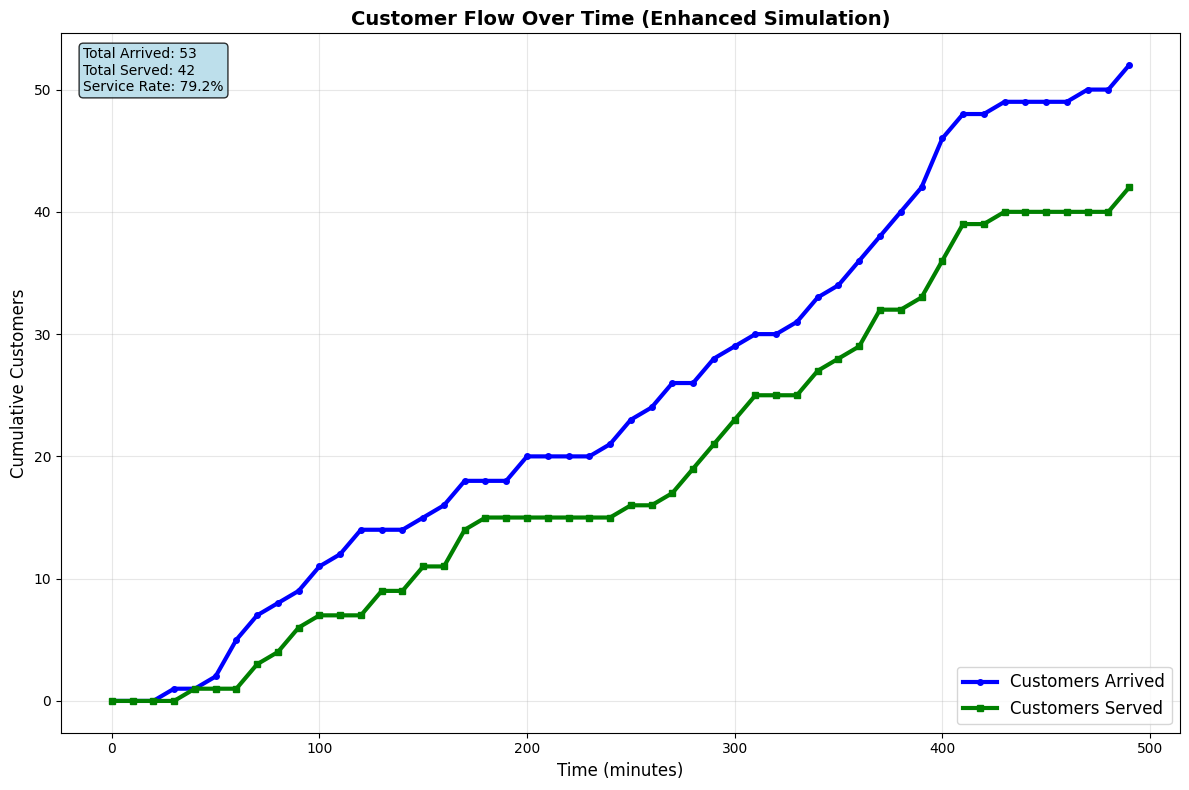

In [82]:
# Time-Series 1: Cumulative Customer Flow Over Time
plt.figure(figsize=(12, 8))
times = enhanced_metrics['time_series']['times']

plt.plot(times, enhanced_metrics['time_series']['customers_arrived_cumulative'], 
         'b-', label='Customers Arrived', linewidth=3, marker='o', markersize=4)
plt.plot(times, enhanced_metrics['time_series']['customers_served_cumulative'], 
         'g-', label='Customers Served', linewidth=3, marker='s', markersize=4)

plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Cumulative Customers', fontsize=12)
plt.title('Customer Flow Over Time (Enhanced Simulation)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add annotations for key statistics
total_arrived = enhanced_metrics['customers_arrived']
total_served = enhanced_metrics['customers_served']
service_rate = (total_served/total_arrived*100) if total_arrived > 0 else 0

plt.text(0.02, 0.98, f'Total Arrived: {total_arrived}\nTotal Served: {total_served}\nService Rate: {service_rate:.1f}%', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

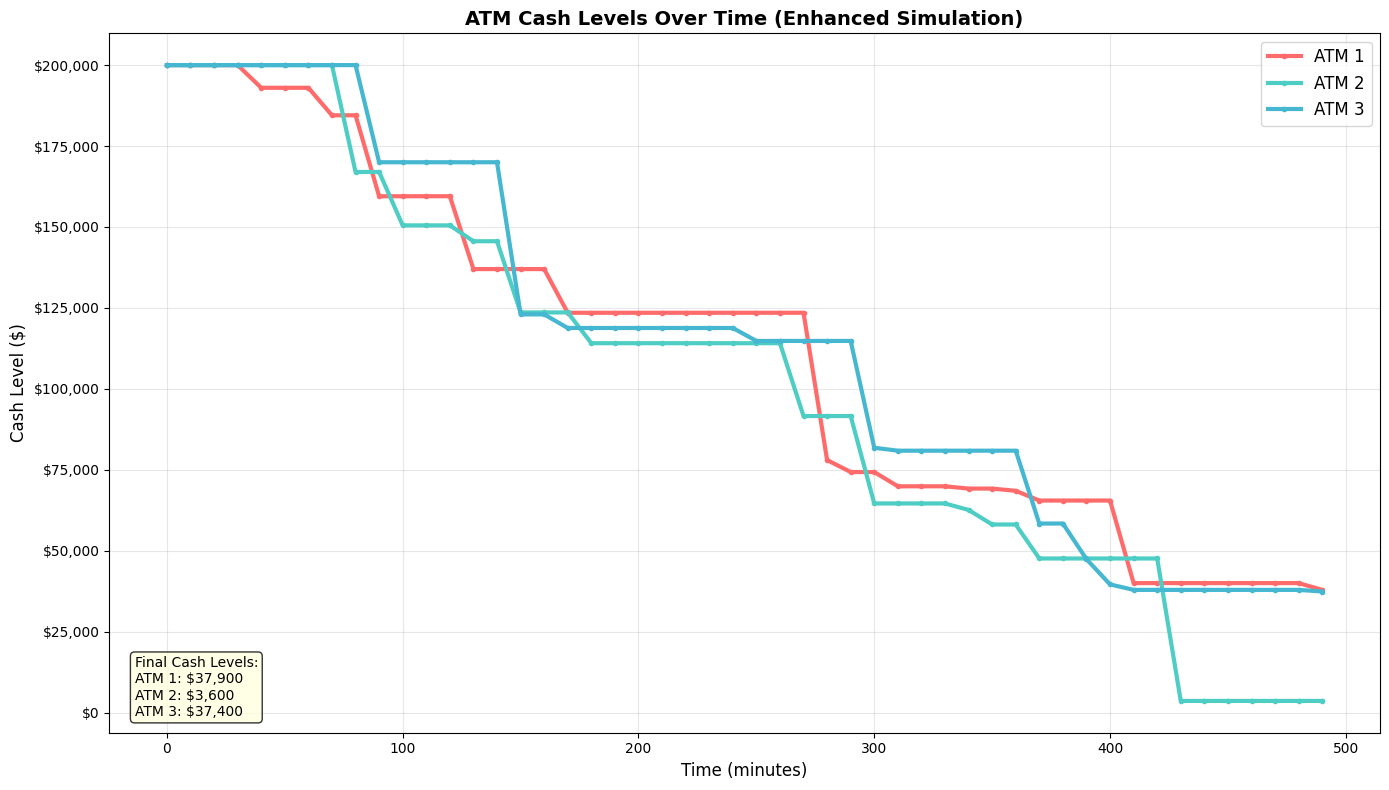

In [83]:
# Time-Series 2: ATM Cash Levels Over Time
plt.figure(figsize=(14, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
times = enhanced_metrics['time_series']['times']

for i, (atm_name, cash_levels) in enumerate(enhanced_metrics['time_series']['atm_cash_levels'].items()):
    plt.plot(times, cash_levels, color=colors[i], label=atm_name.replace('_', ' '), 
             linewidth=3, marker='o', markersize=3)

plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Cash Level ($)', fontsize=12)
plt.title('ATM Cash Levels Over Time (Enhanced Simulation)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Format y-axis to show currency
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Add final cash levels annotation
final_levels = []
for i, atm in enumerate(enhanced_atms):
    final_levels.append(f'ATM {i+1}: ${atm.cash.level:,}')

plt.text(0.02, 0.02, 'Final Cash Levels:\n' + '\n'.join(final_levels), 
         transform=plt.gca().transAxes, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

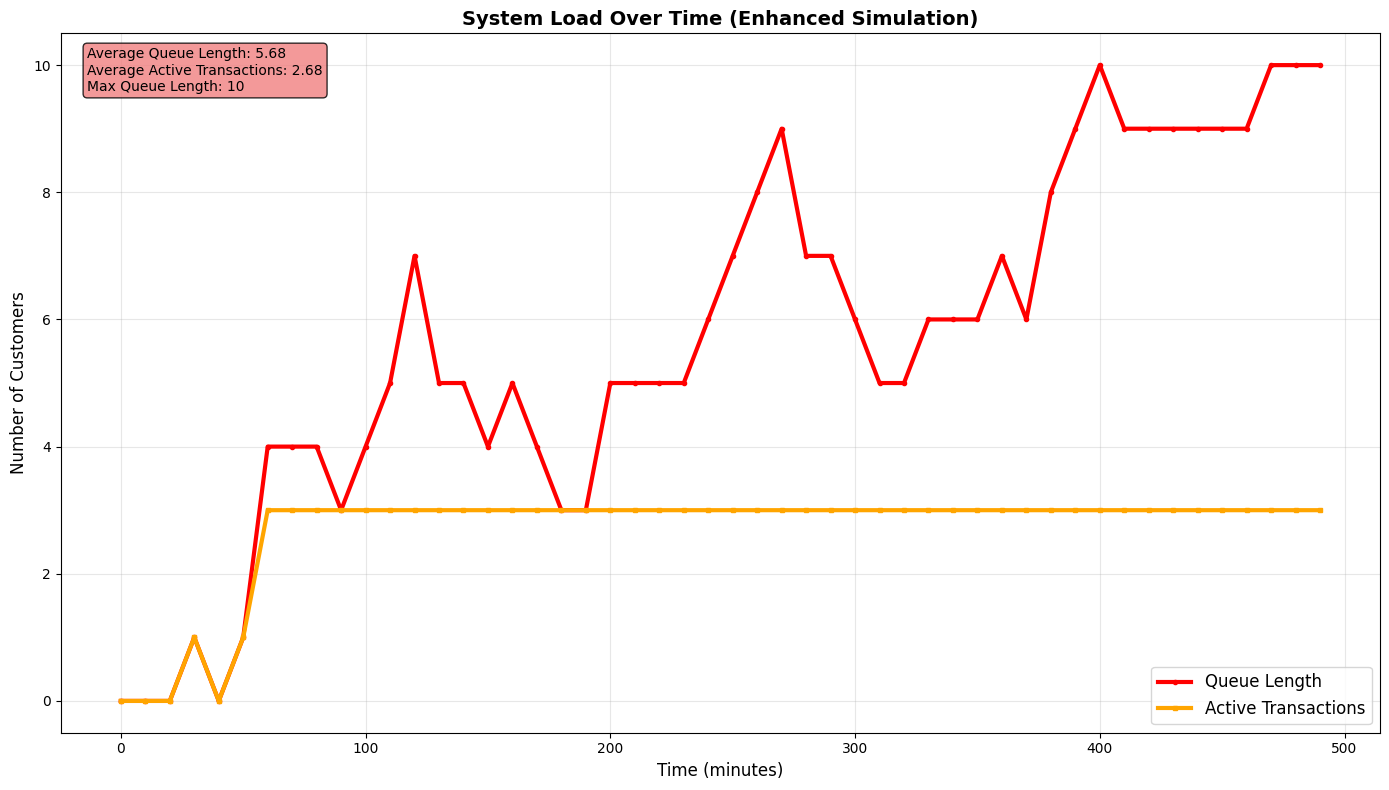

In [84]:
# Time-Series 3: System Load Over Time (Queue Length & Active Transactions)
plt.figure(figsize=(14, 8))
times = enhanced_metrics['time_series']['times']

plt.plot(times, enhanced_metrics['time_series']['queue_lengths'], 
         'r-', label='Queue Length', linewidth=3, marker='o', markersize=3)
plt.plot(times, enhanced_metrics['time_series']['active_transactions'], 
         'orange', label='Active Transactions', linewidth=3, marker='s', markersize=3)

plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('System Load Over Time (Enhanced Simulation)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Calculate and display average system load
avg_queue = np.mean(enhanced_metrics['time_series']['queue_lengths']) if enhanced_metrics['time_series']['queue_lengths'] else 0
avg_active = np.mean(enhanced_metrics['time_series']['active_transactions']) if enhanced_metrics['time_series']['active_transactions'] else 0
max_queue = max(enhanced_metrics['time_series']['queue_lengths']) if enhanced_metrics['time_series']['queue_lengths'] else 0

plt.text(0.02, 0.98, f'Average Queue Length: {avg_queue:.2f}\nAverage Active Transactions: {avg_active:.2f}\nMax Queue Length: {max_queue}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()

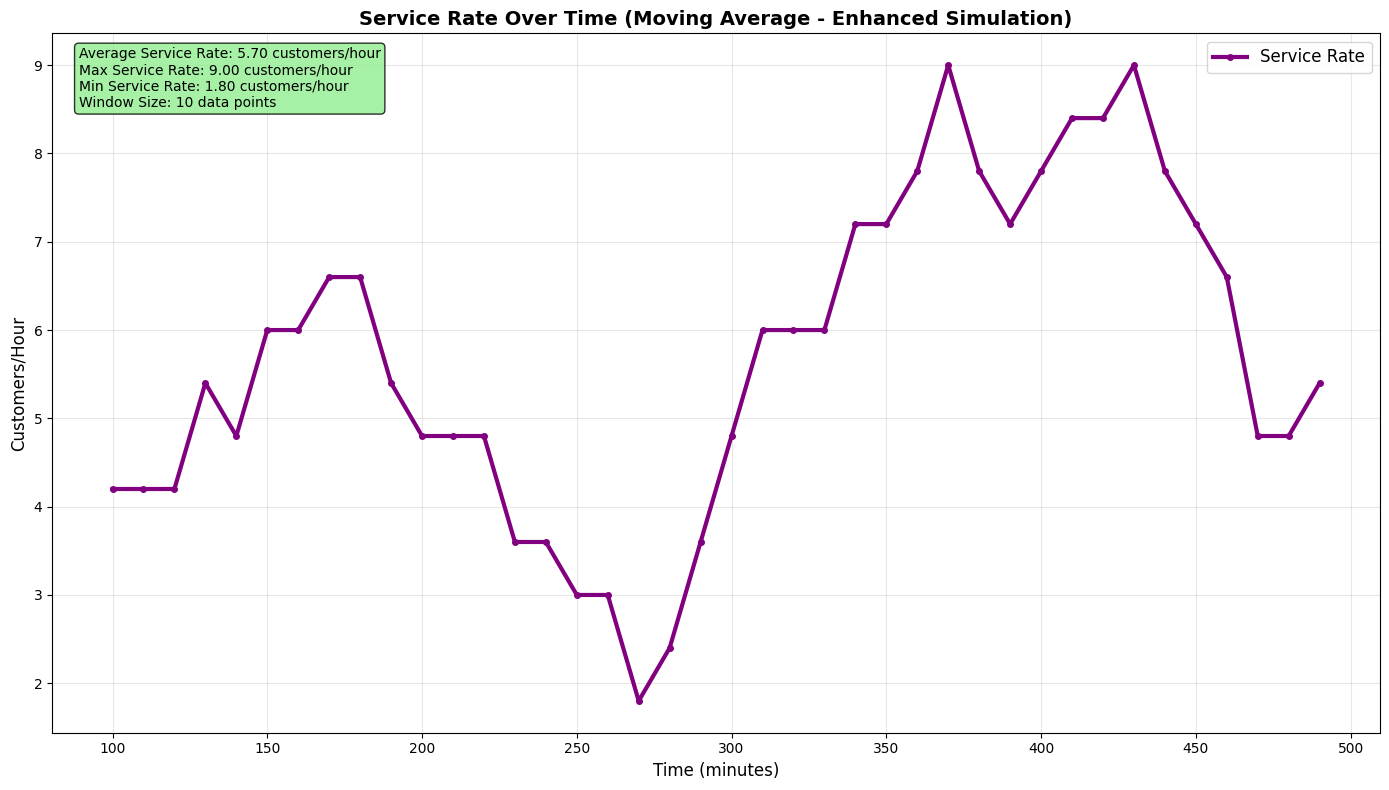

In [85]:
# Time-Series 4: Service Rate Over Time (Moving Average)
plt.figure(figsize=(14, 8))
times = enhanced_metrics['time_series']['times']

if len(times) > 1:
    # Calculate service rate as customers served per time window
    window_size = min(10, len(times) // 4)  # Adaptive window size
    service_rates = []
    rate_times = []
    
    for i in range(window_size, len(times)):
        time_window = times[i] - times[i-window_size]
        customers_in_window = (enhanced_metrics['time_series']['customers_served_cumulative'][i] - 
                              enhanced_metrics['time_series']['customers_served_cumulative'][i-window_size])
        rate = customers_in_window / (time_window / 60) if time_window > 0 else 0  # customers per hour
        service_rates.append(rate)
        rate_times.append(times[i])
    
    plt.plot(rate_times, service_rates, 'purple', linewidth=3, label='Service Rate', 
             marker='o', markersize=4)
    
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('Customers/Hour', fontsize=12)
    plt.title('Service Rate Over Time (Moving Average - Enhanced Simulation)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Calculate and display service rate statistics
    if service_rates:
        avg_service_rate = np.mean(service_rates)
        max_service_rate = max(service_rates)
        min_service_rate = min(service_rates)
        
        plt.text(0.02, 0.98, f'Average Service Rate: {avg_service_rate:.2f} customers/hour\nMax Service Rate: {max_service_rate:.2f} customers/hour\nMin Service Rate: {min_service_rate:.2f} customers/hour\nWindow Size: {window_size} data points', 
                 transform=plt.gca().transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
else:
    plt.text(0.5, 0.5, 'Insufficient Data for Service Rate Calculation', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)
    plt.title('Service Rate Over Time (Moving Average)')

plt.tight_layout()
plt.show()